# Introduction

This tutorial will introduce the basic functionality and usage of MDAnalysis. It will focus on analyzing a Lithium-ion battery electrolyte composed of 49 Li<sup>+</sup>, 49 PF<sub>6</sub><sup>-</sup>, 363 Butyro Nitride, and 237 Ethylene Carbonate.

If you are unfamiliar with the MDAnalysis Universe and AtomGroup, you should check out the tutorial [here]{https://www.mdanalysis.org/MDAnalysisTutorial/basics.html#}. This tutorial will assume a basic familiarity with those data structures.

## Creating a Solution


First, we import solvation_analysis and MDA and instantiate a universe object. 

In [1]:
# imports
import MDAnalysis as mda
import solvation_analysis


# we can use a test trajectory supplied with the package
from solvation_analysis.tests import datafiles

# instantiate Universe
u = mda.Universe(datafiles.bn_fec_data, datafiles.bn_fec_dcd_wrap)

Second, we need to select the AtomGroups for the solute and solvents that will compose the solution. In this tutorial, I am selecting the relevant AtomGroups by the Atom types but you can select the AtomGroups in any way you like. Generally, solvation_analysis will work best when 1) the solute and solvents are disjoint sets and 2) the set of solvents includes all atoms that are not the solute.

In [2]:
# define solute AtomGroup
li_atoms = u.atoms.select_atoms("type 22")

# define solvent AtomGroups
PF6 = u.atoms.select_atoms("byres type 21")
BN = u.atoms.select_atoms("byres type 5")
FEC = u.atoms.select_atoms("byres type 19")

Finally, we can instantiate the Solution from the solute and solvents! The solvents are supplied with a dict of {str: AtomGroups}. The strings should be the names of the solvents or some other convenient identifier because Solution will use this to identify the solvent in all future analysis.

In [3]:
# instantiate solution
from solvation_analysis.solution import Solution

solution = Solution(li_atoms, {'PF6': PF6, 'BN': BN, 'FEC': FEC})

We can see that solution now contains our atoms of interest as attributes:

In [4]:
print(solution.solute)
print(solution.solvents['BN'])

<AtomGroup [<Atom 6734: of type 22 resid 651 and segid SYSTEM>, <Atom 6742: of type 22 resid 652 and segid SYSTEM>, <Atom 6750: of type 22 resid 653 and segid SYSTEM>, ..., <Atom 7102: of type 22 resid 697 and segid SYSTEM>, <Atom 7110: of type 22 resid 698 and segid SYSTEM>, <Atom 7118: of type 22 resid 699 and segid SYSTEM>]>
<AtomGroup [<Atom 1: of type 1 resid 1 and segid SYSTEM>, <Atom 2: of type 2 resid 1 and segid SYSTEM>, <Atom 3: of type 3 resid 1 and segid SYSTEM>, ..., <Atom 4354: of type 10 resid 363 and segid SYSTEM>, <Atom 4355: of type 11 resid 363 and segid SYSTEM>, <Atom 4356: of type 12 resid 363 and segid SYSTEM>]>


## Running and Validating a Solution

Now that we have a solution, we can run the analysis! This follows the typical MDA analysis interface of calling `analysis.run()`. When `run` is called, a few things happen:


First, Solution calculates the RDF between the solute and each solvent and
uses it to identify the radius of the first solvation shell.

Second, Solution finds all atoms in the first solvation shell, using
the cutoff radii for each solvent. This analysis is repeated for each solute at every frame in the
analysis and the data is compiled into a pandas.DataFrame.

Finally, Solution instantiates Speciation, Coordination, and Pairing
objects from the solvation_data, providing a convenient interface for
further analysis. These will be discussed later in the tutorial.

Now let's do it!

In [5]:
# run analysis
solution.run()

/Users/hugo/opt/anaconda3/envs/solvation-analysis/lib/python3.8/site-packages/solvation_analysis/rdf_parser.py:159: UserWarning: No solvation shell detected.
  warnings.warn("No solvation shell detected.")


AssertionError: Solution could not identify a solvation radius for PF6. Please manually enter missing radii by editing the radii dict and rerun the analysis.

Oh no! Solution failed to identify a radius for pf6! Since no solvation radius was identified, it's impossible to define a solvation shell. Let's see what went wrong by inspecting the radii dictionary and the PF6 RDF that was generated by Solution.

{'PF6': nan, 'BN': 2.614678772286192, 'FEC': 2.431583419310968}


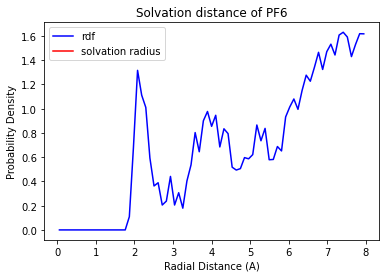

In [6]:
# we need this just to display our plot
import matplotlib.pyplot as plt

# inspect the missing value
print(solution.radii)

# plot the RDF!
solution.plot_solvation_radius('PF6')
plt.show()

The solvation radius seems to be just a bit too jagged to be successfully identified, so it's appearing as a nan value in the radii dict. Let's look at the solvation of bn and fec for comparison.

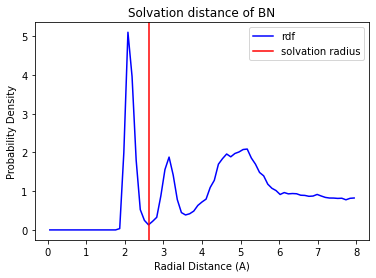

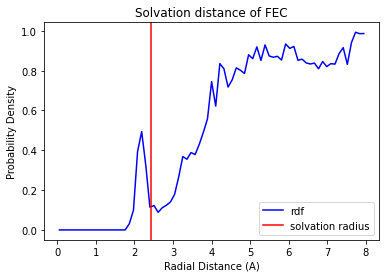

In [7]:
# plot the BN and FEC RDFs
solution.plot_solvation_radius('BN')
solution.plot_solvation_radius('FEC')
plt.show()

Fortunately, we can easily assign a solvation radius for PF6, which looks to be about 2.6 A. We can simply overwrite the radius dict and take another look at the RDF.

{'PF6': 2.6, 'BN': 2.614678772286192, 'FEC': 2.431583419310968}


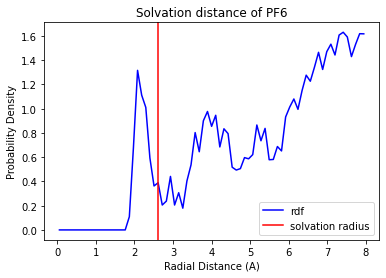

In [8]:
# assign a new PF6 radius
solution.radii['PF6'] = 2.6

# inspect the radii
print(solution.radii)

# check that our new radius looks good
solution.plot_solvation_radius('PF6')
plt.show()

There! Now we have solvation radii for all our species and we are ready to rerun our analysis!

In [9]:
# works fine this time
solution.run()

## Basic Analysis with Coordination and Pairing

As mentioned before, Solution automatically instantiates Coordination, Pairing, and Speciation objects as attributes to make further analysis easy. That means that we can automatically access the analysis methods from the Solution class. Lets take a look at the coordination numbers of our solvents. Here, the coordination number can be interpreted as the mean number of solvent coorinated with each solute. So in the case below, there are on average 0.253 FEC coordinated with each Li ion.

In [10]:
# inspect the coordination numbers
solution.coordination.cn_dict

{'BN': 4.328571428571428,
 'FEC': 0.2530612244897959,
 'PF6': 0.12857142857142856}

We using a similar interface to look at the percentage of solutes paired with each solvent. Here, the pairing is the percentage of solutes that are coordinated with *ANY* solvent. So in the example below, 100% of Li ions are coordinated with BN and 21% of Li ions are coordinated with FEC.

In [11]:
# inspect the pairing percentages
solution.pairing.pairing_dict

{'BN': 1.0, 'FEC': 0.21020408163265306, 'PF6': 0.12040816326530612}

If we want to view this information dynamically by frame, we can instead look at the by-frame data. In the case of coordination numbers we can call the following cell. This will show us the coordination numbers at each frame instead of averaged over the whole trajectory.

In [12]:
# inspect coordination numbers by frame
solution.coordination.cn_by_frame

frame,0,1,2,3,4,5,6,7,8,9
res_name,,,,,,,,,,
BN,0.428571,0.432653,0.428571,0.432653,0.428571,0.436735,0.432653,0.440816,0.432653,0.434694
FEC,0.020408,0.022449,0.024490,0.020408,0.028571,0.040816,0.022449,0.026531,0.026531,0.020408
PF6,0.016327,0.012245,0.016327,0.012245,0.014286,0.006122,0.010204,0.014286,0.014286,0.012245


This systems was already equilibrated, so unsurpringly, there isn't much change.

## Exploratory Analysis with Speciation

Speciation is design to complement a more interactive style of analysis. It provides tools for identifying the most common solvation shells, finding specific examples of them, and selecting those examples for further analysis or visualization. The summary data of the speciation statistics is collected in `speciation_percent` which shows the percentage of solutes that are solvated by a shell with the composition shown in the columns.

In [13]:
solution.speciation.speciation_percent

,BN,FEC,PF6,count
0,5,0,0,0.357143
1,4,0,0,0.310204
2,4,1,0,0.116327
3,4,0,1,0.089796
4,5,1,0,0.034694
5,3,2,0,0.018367
6,3,0,1,0.016327
7,3,1,0,0.016327
8,4,2,0,0.014286
9,3,0,2,0.008163


To calculate summary statistics on this data, such as to determine what percent of shells have 4 BN with any number of FEC or PF6, one could call:

In [14]:
# calculate # of shells with 4 BN
solution.speciation.shell_percent({'BN': 4})

0.5306122448979591

In [15]:
# make it more specific by specifying 1 PF6
solution.speciation.shell_percent({'BN': 4, 'PF6': 1})

0.08979591836734693

Perhaps we are interested in shells with 4 BN, 0 FEC, and 1 PF6. We can find these with `speciation.find_shells`. This will show us all of the solute in every frame with the given composition. Let's see it in action

In [16]:
# find all shells matching the given dictionary
solution.speciation.find_shells({'BN': 4, 'FEC': 0, 'PF6': 1})

res_name             BN  FEC  PF6
frame solvated_atom              
0     6               4    0    1
      18              4    0    1
      21              4    0    1
      22              4    0    1
      34              4    0    1
      41              4    0    1
      44              4    0    1
1     18              4    0    1
      19              4    0    1
      21              4    0    1
      22              4    0    1
      34              4    0    1
      44              4    0    1
2     6               4    0    1
      18              4    0    1
      21              4    0    1
      23              4    0    1
      28              4    0    1
3     6               4    0    1
      18              4    0    1
      28              4    0    1
      31              4    0    1
      34              4    0    1
4     6               4    0    1
      17              4    0    1
      23              4    0    1
      31              4    0    1
      34              4    0    1
5     6               4    0    1
6     19              4    0    1
      34              4    0    1
7     6               4    0    1
      17              4    0    1
      19              4    0    1
      31              4    0    1
      34              4    0    1
8     6               4    0    1
      17              4    0    1
      31              4    0    1
      44              4    0    1
9     15              4    0    1
      19              4    0    1
      31              4    0    1
      44              4    0    1

Awesome! Let's see what we have here by inspecting the data associated with the cluster. I like prime numbers, so lets go with solute 17 in frame 7. To do this, we will use the selection methods in the solution class. Setting `as_df=True` will make the function return a DataFrame instead of an AtomGroup

In [17]:
# get the shell DataFrame
solution.solvation_shell(17, 7, as_df=True)

,dist,res_name,res_id
atom_id,,,
7034,2.062944,PF6,640
1853,2.113351,BN,155
3233,2.205047,BN,270
1601,2.271131,BN,134
3641,2.427539,BN,304


We can see that this matches the desired shell composition and shows us the indexes of the involved Atoms and Residues. Additionally, it shows us the distane of the closest atom of each solvent. If we want to return the AtomGroup instead of the DataFrame that's easy as well.

In [18]:
# get the shell AtomGroup
solution.solvation_shell(17, 7)

<AtomGroup with 56 atoms>

## The Core Solvation Data Structure

All of the analyses in `solvation_analysis` are built on top of the solvation data, which is collected in a pandas.DataFrame so that it can be parsed with vectorized numpy and pandas operations. Unless you want to design your own analyses, you probably won't have a need to interact with this much, but it still might be useful to take a look at.

In [19]:
# the core data structure
solution.solvation_data

dist res_name  res_id
frame solvated_atom atom_id                           
0     0             4169     2.103129       BN     348
                    2309     2.127130       BN     193
                    6111     2.176079      FEC     539
                    1313     2.316887       BN     110
                    2609     2.376575       BN     218
...                               ...      ...     ...
9     48            653      2.018652       BN      55
                    4001     2.092055       BN     334
                    1469     2.148709       BN     123
                    3329     2.184715       BN     278
                    1805     2.371709       BN     151

[2308 rows x 3 columns]

As you can see, the solvation data is indexed by the frame, solvated_atom, and atom_id, which provide a unique identifier for each atom involved in solvation. Critically, the solvation only includes atoms within the first solvation radius, because the res_id's are kept, we can determine the molecules involved in solvation. This is a low-memory approach to storing solvation data.